 Email Spam Classification using Naive Bayes

## Objective
This project aims to build an email spam classifier using the Naive Bayes algorithm. Email spam is a significant problem for both individuals and organizations, costing time, resources, and sometimes leading to security breaches. By leveraging machine learning, specifically the Naive Bayes classification algorithm, we can automatically identify and filter spam emails with high accuracy.

## Business Problem
Email service providers need efficient systems to detect and filter spam messages automatically. Manual filtering is impractical given the volume of emails that users receive daily. A reliable automated system would:
1. Reduce user exposure to potentially harmful content
2. Save time spent manually filtering spam
3. Improve overall user experience
4. Reduce server resource usage by filtering spam before delivery

## What is Naive Bayes?
Naive Bayes is a probabilistic classification algorithm based on Bayes' theorem with an assumption of independence among predictors. Despite this "naive" assumption, the algorithm performs remarkably well for many real-world problems, especially in text classification tasks like spam detection.

### Mathematical Intuition

Bayes' theorem provides a way to calculate the probability of a hypothesis given our prior knowledge:

$$P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}$$

Where:
- $P(A|B)$ is the posterior probability of class A given predictor B
- $P(B|A)$ is the likelihood of predictor B given class A
- $P(A)$ is the prior probability of class A
- $P(B)$ is the prior probability of predictor B

In the context of spam classification:
- $P(\text{spam}|\text{message})$ is the probability that a message is spam given its content
- $P(\text{message}|\text{spam})$ is the probability of observing the message content in spam emails
- $P(\text{spam})$ is the overall probability of any message being spam
- $P(\text{message})$ is the probability of that specific message content

For text classification with multiple words, the formula becomes:

$$P(\text{spam}|w_1, w_2, ..., w_n) = \frac{P(w_1, w_2, ..., w_n|\text{spam}) \times P(\text{spam})}{P(w_1, w_2, ..., w_n)}$$

The "naive" assumption comes into play here: we assume that the presence of each word is independent of others. This simplifies the calculation to:

$$P(\text{spam}|w_1, w_2, ..., w_n) \propto P(\text{spam}) \times \prod_{i=1}^{n} P(w_i|\text{spam})$$

For classification, we compare:
$$P(\text{spam}|message) \text{ vs } P(\text{ham}|message)$$

And classify as spam if the first probability is higher.

### Types of Naive Bayes

1. **Multinomial Naive Bayes** - Used for discrete counts (e.g., word frequencies in text)
2. **Gaussian Naive Bayes** - Used when features follow a normal distribution
3. **Bernoulli Naive Bayes** - Used for binary features (presence/absence)

For text classification like our spam detection problem, Multinomial Naive Bayes is most appropriate.

## Let's start coding!

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set aesthetics for plots
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
# Load the dataset
df = pd.read_csv("/content/spam (2).csv")

In [4]:
# Display the first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Basic dataset information
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Category    0
Message     0
dtype: int64


In [7]:
# Dataset dimensions
print(f"\nDataset shape: {df.shape}")


Dataset shape: (5572, 2)


In [8]:
# Distribution of spam vs ham
print("\nClass distribution:")
class_distribution = df['Category'].value_counts()
print(class_distribution)
print(f"Percentage of spam messages: {(class_distribution['spam'] / len(df)) * 100:.2f}%")


Class distribution:
Category
ham     4825
spam     747
Name: count, dtype: int64
Percentage of spam messages: 13.41%


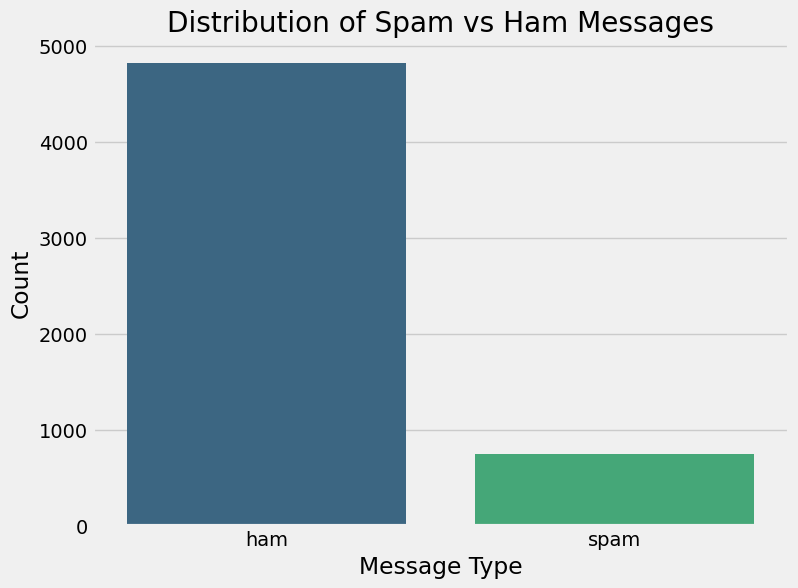

In [9]:
# Visualize the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Category', data=df, palette='viridis')
plt.title('Distribution of Spam vs Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

In [10]:
# More detailed statistics about the messages
df.groupby('Category').describe()

# Create a new binary column for easier processing
df['spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

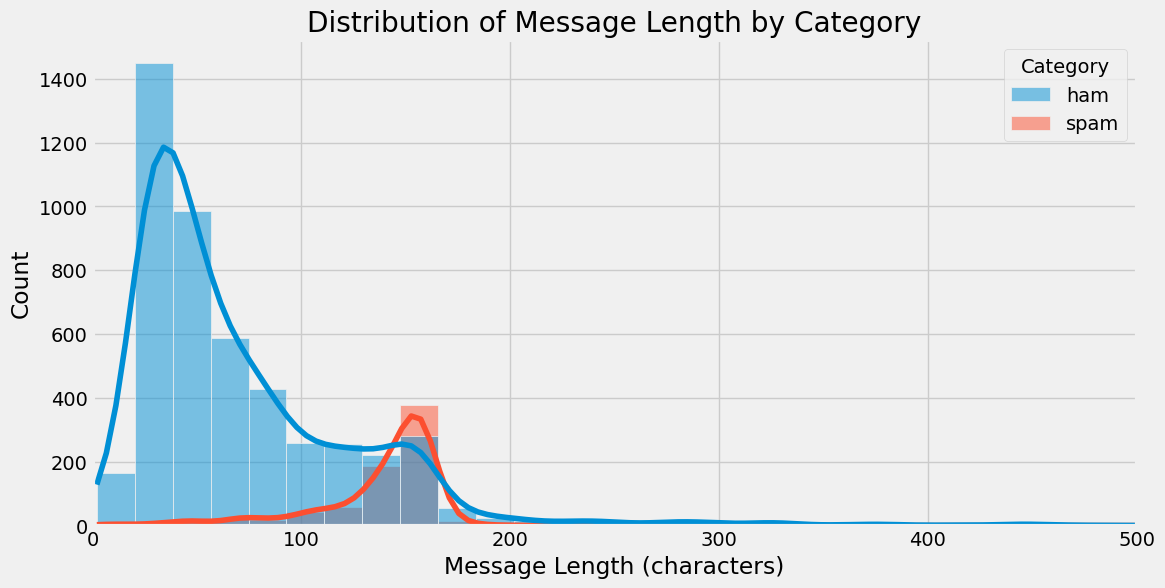

In [11]:
# Message length analysis
df['message_length'] = df['Message'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='message_length', hue='Category', bins=50, kde=True)
plt.title('Distribution of Message Length by Category')
plt.xlabel('Message Length (characters)')
plt.xlim(0, 500)  # Focus on the main distribution area
plt.show()

In [12]:
# Compare average message lengths
print("Average message length:")
print(df.groupby('Category')['message_length'].mean())

Average message length:
Category
ham      71.44829
spam    137.98929
Name: message_length, dtype: float64


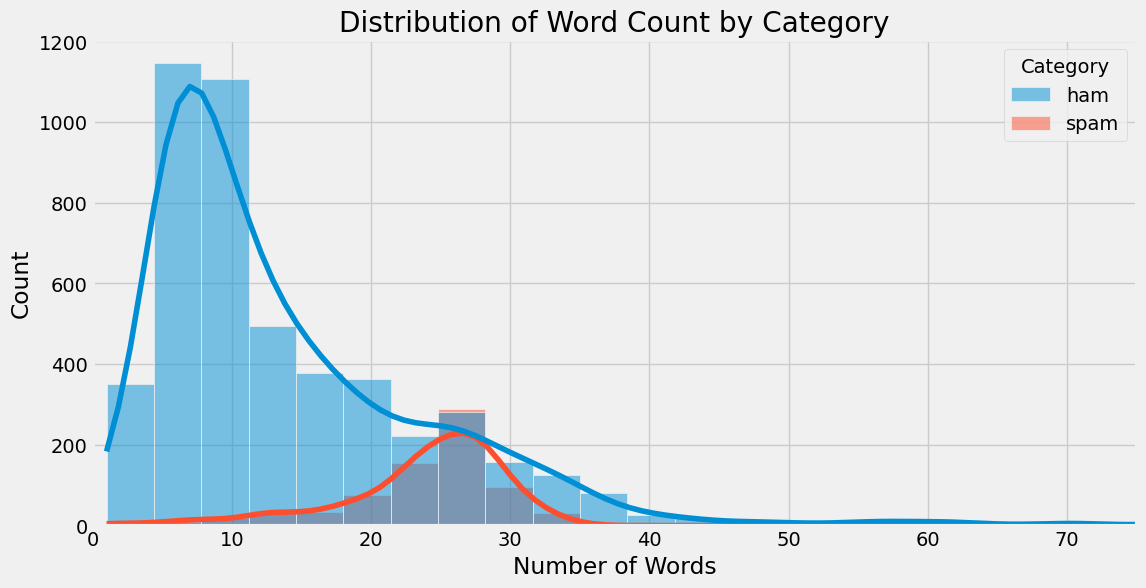

In [13]:
# Word count analysis
df['word_count'] = df['Message'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='Category', bins=50, kde=True)
plt.title('Distribution of Word Count by Category')
plt.xlabel('Number of Words')
plt.xlim(0, 75)  # Focus on the main distribution area
plt.show()

In [14]:
# Compare average word counts
print("Average word count:")
print(df.groupby('Category')['word_count'].mean())

Average word count:
Category
ham     14.310259
spam    23.812584
Name: word_count, dtype: float64


In [15]:
# Function to get common words
def get_top_words(category, top_n=20):
    words = ' '.join(df[df['Category'] == category]['Message']).lower()
    words = re.sub(r'[^\w\s]', '', words)  # Remove punctuation
    word_counts = pd.Series(words.split()).value_counts()
    return word_counts.head(top_n)

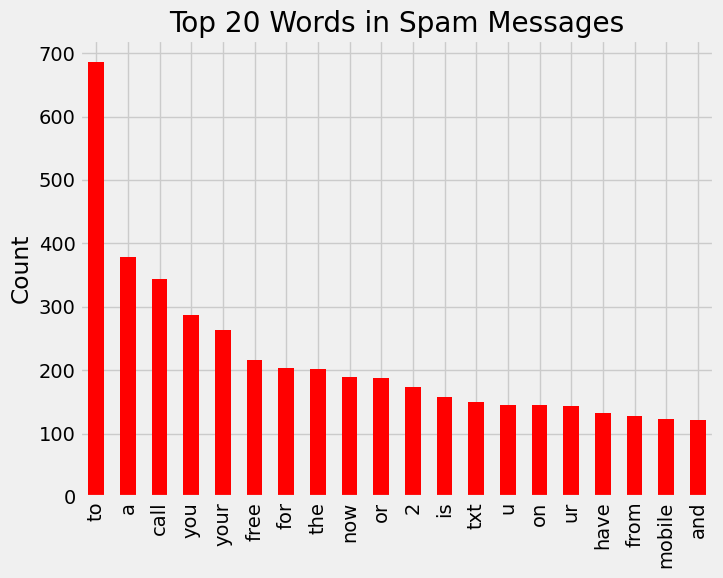

In [16]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
get_top_words('spam').plot(kind='bar', color='red')
plt.title('Top 20 Words in Spam Messages')
plt.ylabel('Count')
plt.tight_layout()

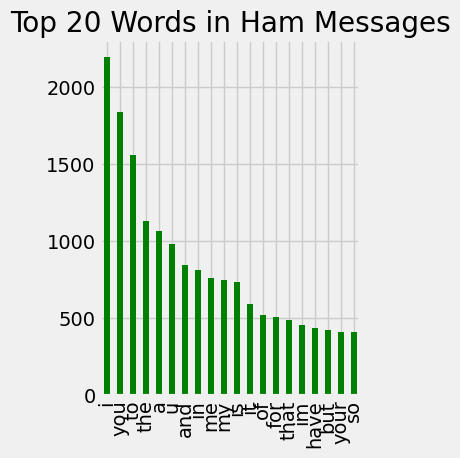

In [17]:
# Most common words in ham
plt.subplot(1, 2, 2)
get_top_words('ham').plot(kind='bar', color='green')
plt.title('Top 20 Words in Ham Messages')
plt.tight_layout()
plt.show()

In [18]:
# Download NLTK resources if not already present
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
# Function to get common words excluding stopwords
def get_top_words_no_stopwords(category, top_n=20):
    stop_words = set(stopwords.words('english'))
    words = ' '.join(df[df['Category'] == category]['Message']).lower()
    words = re.sub(r'[^\w\s]', '', words)  # Remove punctuation
    word_counts = pd.Series([word for word in words.split() if word not in stop_words]).value_counts()
    return word_counts.head(top_n)

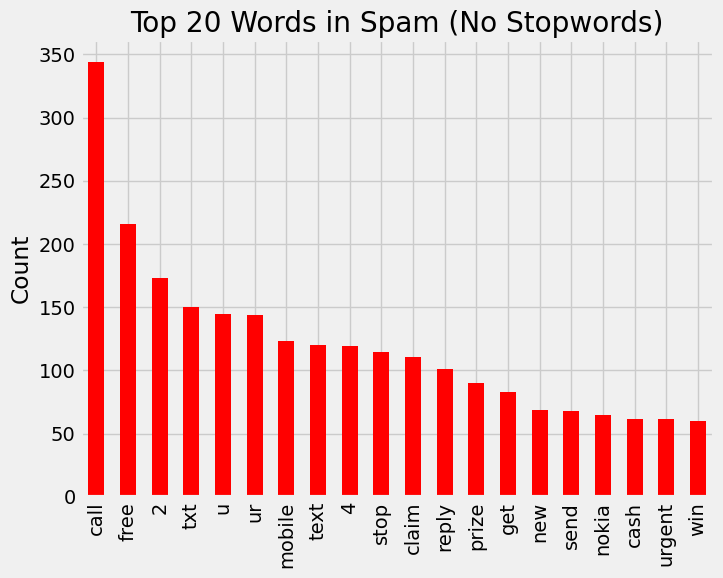

In [20]:
# Most common words in spam (no stopwords)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
get_top_words_no_stopwords('spam').plot(kind='bar', color='red')
plt.title('Top 20 Words in Spam (No Stopwords)')
plt.ylabel('Count')
plt.tight_layout()

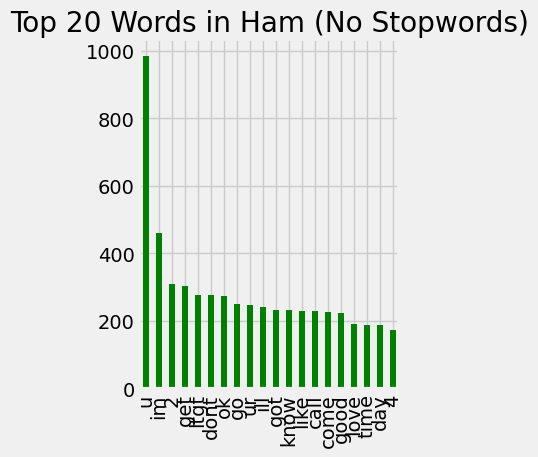

In [21]:
# Most common words in ham (no stopwords)
plt.subplot(1, 2, 2)
get_top_words_no_stopwords('ham').plot(kind='bar', color='green')
plt.title('Top 20 Words in Ham (No Stopwords)')
plt.tight_layout()
plt.show()

In [22]:

## Text Preprocessing


# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # Join back to string
    return ' '.join(words)


In [23]:
# Apply preprocessing to the Message column
df['processed_message'] = df['Message'].apply(preprocess_text)

# Display a few examples
print("Original vs Processed Messages:")
for i in range(5):
    print(f"Original: {df['Message'].iloc[i]}")
    print(f"Processed: {df['processed_message'].iloc[i]}")
    print("-" * 100)

Original vs Processed Messages:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed: go jurong point crazi avail bugi n great world la e buffet cine got amor wat
----------------------------------------------------------------------------------------------------
Original: Ok lar... Joking wif u oni...
Processed: ok lar joke wif u oni
----------------------------------------------------------------------------------------------------
Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Processed: free entri wkli comp win fa cup final tkt st may text fa receiv entri questionstd txt ratetc appli over
----------------------------------------------------------------------------------------------------
Original: U dun say so early hor... U c already then say...
Processed: u dun say earli hor u c alread

Text preprocessing is crucial for improving the performance of our model. This function:
1. Converts text to lowercase
2. Removes punctuation and numbers
3. Tokenizes the text (splits it into individual words)
4. Removes stopwords (common words that don't carry much meaning)
5. Applies stemming (reducing words to their root form)

In [24]:
# Split data into training and testing sets
X = df['processed_message']
y = df['spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Spam ratio in training set: {y_train.mean():.4f}")
print(f"Spam ratio in testing set: {y_test.mean():.4f}")

Training set size: 4457
Testing set size: 1115
Spam ratio in training set: 0.1342
Spam ratio in testing set: 0.1336


In [25]:
## Feature Extraction

# Create vectorizer
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)

# Summary of vectorization
print(f"Number of features (unique words): {len(vectorizer.vocabulary_)}")
print(f"Shape of feature matrix: {X_train_counts.shape}")

# Check a few feature names
print("\nSample of features (words):")
features = vectorizer.get_feature_names_out()
print(features[:20])  # First 20 features

Number of features (unique words): 6279
Shape of feature matrix: (4457, 6279)

Sample of features (words):
['____' 'aa' 'aah' 'aaniy' 'aathilov' 'aathiwher' 'ab' 'abbey' 'abdomen'
 'abeg' 'abelu' 'aberdeen' 'abi' 'abil' 'abiola' 'abj' 'abl' 'abnorm'
 'abouta' 'absenc']


In [26]:
# Alternative: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

print(f"\nTF-IDF Shape: {X_train_tfidf.shape}")


TF-IDF Shape: (4457, 6279)


TF-IDF (Term Frequency-Inverse Document Frequency) is an alternative to simple word counts. It weights words based on how important they are to a document, giving higher weights to words that are specific to certain documents and lower weights to common words.


## Naive Bayes Model Training and Evaluation

In [28]:
# Train Multinomial Naive Bayes with Count Vectorizer
nb_count = MultinomialNB()
nb_count.fit(X_train_tfidf, y_train)


MultinomialNB()

In [29]:
# Transform test data
X_test_counts = vectorizer.transform(X_test)

In [30]:
y_pred_count = nb_count.predict(X_test_counts)

In [31]:
# Evaluation
print("Naive Bayes with Count Vectorizer:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_count):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_count))

Naive Bayes with Count Vectorizer:
Accuracy: 0.9749

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       0.98      0.83      0.90       149

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



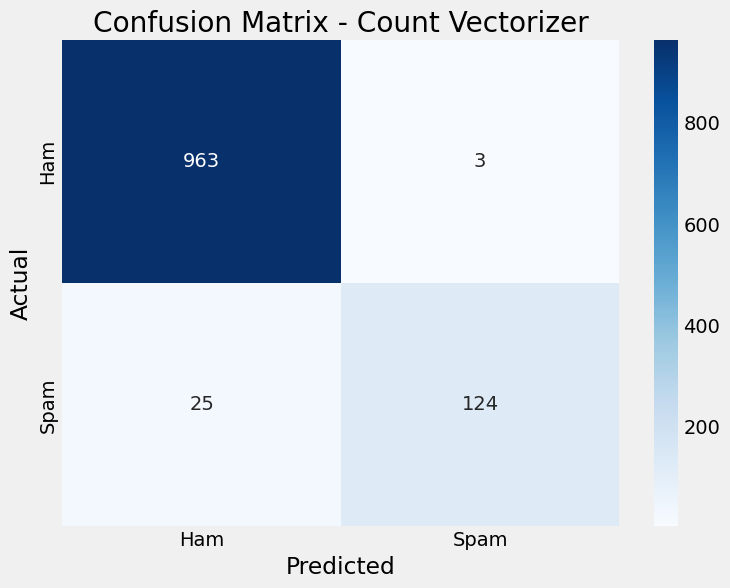

In [32]:
# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_count)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Count Vectorizer')
plt.show()

In [39]:
tfidf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

In [40]:
# Train and evaluate the TF-IDF pipeline
tfidf_pipeline.fit(X_train, y_train)
y_pred_tfidf_pipe = tfidf_pipeline.predict(X_test)
print("TF-IDF Pipeline Accuracy:", accuracy_score(y_test, y_pred_tfidf_pipe))

TF-IDF Pipeline Accuracy: 0.9632286995515695


In [41]:
from sklearn.model_selection import GridSearchCV

# Define parameters for grid search
parameters = {
    'vectorizer__max_features': [1000, 3000, 5000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Unigrams or unigrams+bigrams
    'classifier__alpha': [0.01, 0.1, 0.5, 1.0],  # Smoothing parameter
}

In [42]:
grid_search = GridSearchCV(
    tfidf_pipeline,
    parameters,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

In [43]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.01, 0.1, 0.5, 1.0],
                         'vectorizer__max_features': [1000, 3000, 5000],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

In [44]:
# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print("Best model test accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

Best parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}
Best cross-validation score: 0.9813783072377991
Best model test accuracy: 0.9820627802690582

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.98      0.88      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [33]:
## Practical Application: Testing with New Messages


In [45]:
# Function to predict spam probability for new messages
def predict_spam_probability(messages, model):
    probabilities = model.predict_proba(messages)
    return probabilities[:, 1]  # Probability of being spam

In [55]:
test_messages = [
    "Congratulations! You've won a free trip to the Bahamas. Call now to claim your prize!",
    "Hey, can we meet for coffee tomorrow at 3pm?",
    "URGENT!! Your bank account has been compromised. HURRY !!! Click here to verify your information.",
    "I'll bring the documents you requested to the meeting.",
    "FREE FREE FREE!!! Limited time offer on all products. Huge Discount!",
    "The project meeting has been rescheduled to Monday at 10am."
]

In [56]:
# Predict and display results
probs = predict_spam_probability(test_messages, best_model)
predictions = best_model.predict(test_messages)

In [57]:
# Predict and display results
probs = predict_spam_probability(test_messages, best_model)
predictions = best_model.predict(test_messages)

print("Message Spam Analysis:")
for i, message in enumerate(test_messages):
    print(f"\nMessage: {message}")
    print(f"Spam Probability: {probs[i]:.4f}")
    print(f"Classification: {'Spam' if predictions[i] == 1 else 'Ham'}")

Message Spam Analysis:

Message: Congratulations! You've won a free trip to the Bahamas. Call now to claim your prize!
Spam Probability: 0.9760
Classification: Spam

Message: Hey, can we meet for coffee tomorrow at 3pm?
Spam Probability: 0.0051
Classification: Ham

Message: URGENT!! Your bank account has been compromised. HURRY !!! Click here to verify your information.
Spam Probability: 0.3867
Classification: Ham

Message: I'll bring the documents you requested to the meeting.
Spam Probability: 0.0188
Classification: Ham

Message: FREE FREE FREE!!! Limited time offer on all products. Huge Discount!
Spam Probability: 0.5269
Classification: Spam

Message: The project meeting has been rescheduled to Monday at 10am.
Spam Probability: 0.0049
Classification: Ham


## Final Thoughts

Naive Bayes has proven to be an effective and efficient algorithm for spam classification, despite its simplistic assumptions. Its high accuracy, combined with its computational efficiency, makes it an excellent choice for text classification tasks like spam detection. The model we've developed can be easily integrated into email systems to automatically filter spam, improving user experience and system efficiency.

Future improvements could include:
1. Using more advanced text preprocessing techniques
2. Incorporating additional features like email sender information
3. Regular model updates to adapt to evolving spam tactics
4. Ensemble methods combining Naive Bayes with other algorithms

This project demonstrates how machine learning can solve real-world problems efficiently, providing tangible benefits to both users and organizations.